# Exercise 08 RNN & NLP - Instruction

## Pedagogy

This notebook serves as an instruction for implementing RNNs using PyTorch for NLP purpose.

Please use this notebook as a reference and guide to complete the assignment.

## Import libraries

In this notebook, we will use the following new libraries:
- `torchtext` for data processing utilities and popular datasets for NLP.

Please install the new libraries before using them.

In [1]:
!conda install pytorch::torchtext -y

Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [2]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

from torchtext.data.utils import get_tokenizer # for tokenization
from torchtext.vocab import build_vocab_from_iterator # for creating vocabulary

In [3]:
# suppress all warnings
warnings.filterwarnings("ignore")

# Instruction

In this notebook, we will build a text classification model using RNN, more specifically, LSTM.

The problem to be solved is to classify different news into one of the 4 pre-defined classes:

|Class|Example news|
|-|-|
|World|France marks the 'other D-Day' Two days of celebrations to honour the Allied veterans who liberated southern France near a climax...|
|Sports|Galaxy, Crew Play to 0-0 Tie (AP) AP - Kevin Hartman made seven saves for Los Angeles, and Jon Busch had two saves for Columbus as the Galaxy and Crew played to a 0-0 tie Saturday night...|
|Business|Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again...|
|Sci/Tech|Apple to open second Japanese retail store this month (MacCentral) MacCentral - Apple Computer Inc. will open its second Japanese retail store later this month in the western Japanese city of Osaka, it said Thursday...|

## Step 1. Build the data pipeline

We will use the [AG News Dataset](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) which is a collection of news articles. Each news article is classified into one of the 4 pre-defined classes: world, sports, business, and sci/tech.

In this step, we need to:
- Load the dataset from the `ag_news_dataset.csv` file
- Tokenization
- Create the vocabulary
- Cut/Pad each news articles to the same sequence length
- Create the tensor dataset and dataloader for the training, validation, and test set

In [4]:
# load dataset
ag_news_df = pd.read_csv('ag_news_dataset.csv')
classes = ['World', 'Sports', 'Business', 'Sci/Tec']
ag_news_df

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
127595,Around the world Ukrainian presidential candid...,0
127596,Void is filled with Clement With the supply of...,1
127597,Martinez leaves bitter Like Roger Clemens did ...,1
127598,5 of arthritis patients in Singapore take Bext...,2


In [5]:
# get the tokenizer
tokenizer = get_tokenizer('basic_english')

# define an intertor function to perform tokenization
def yield_tokens(df, tokenizer):
    for i in range(len(df)):
        yield tokenizer(df['text'].values[i])

# create the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(ag_news_df, tokenizer), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [6]:
# print the number of unique tokens in the vocabulary
print('The number of unique tokens in the vocabulary:', len(vocab))

The number of unique tokens in the vocabulary: 98635


When creating the vocabulary, we tokenize each news article as a sequence of tokens and add them to the vocabulary.

We also add a special token `<unk>` in the vocabulary, which represents the unknown token.

It's very common that there are unknown tokens in the unseen data, and we need to deal with these unknown tokens.

By add `<unk>` in the vocabulary and `set_default_index(vocab['<unk>'])`, all the unknown tokens will be assigned to the default index.

In [7]:
# cut/pad all news articles to the same sequence length
seq_length = 20 # number of tokens in the sequence for each news articles
X = []
for i in range(len(ag_news_df)):
    text = ag_news_df['text'].values[i]
    text = vocab(tokenizer(text))
    if len(text) < seq_length:
        text = text + [0] * (seq_length - len(text)) # pad the sequence with 0
    else:
        text = text[:seq_length] # cut the sequence to the pre-defined length
    X.append(text)
X = np.array(X)
print('The shape of input:', X.shape)
y = ag_news_df['label'].values
print('The shape of label:', y.shape)

The shape of input: (127600, 20)
The shape of label: (127600,)


We can see the shape of input `X` is `127600, 20`:
- 127600 means there are 127600 sequences in the dataset, each sequence represent a news article.
- 20 means the sequence length is 20, each sequence contains 20 tokens.

The shape of label `y` is `127600`:
- Each sequence has a corresponding label, representing the class of the news article.

In [8]:
# create the tensor dataset
ag_news_ds = TensorDataset(
    torch.tensor(X, dtype = torch.int64),
    torch.tensor(y, dtype = torch.int64)
)

In [9]:
# split the dataset into the training, validation, and test set
train_val_ds, test_ds = random_split(ag_news_ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [10]:
# create the training, validation, and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [11]:
# get one batch and print its shape
for batch in train_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([512, 20])
torch.Size([512])


## Step 2. Create the LSTM-based text classifier

For text classification task, the input is a sequence of tokens, the output is a class. So we need to use the many-to-one architecture of RNN, like the following picture shows:

![](https://i.stack.imgur.com/F7qzk.jpg)

In this step, we need to:
- Define a custom class for the text classifier
    - Specify the network structure
        - The first layer is `nn.Embedding()`
    - Specify the forward method
        - There is recurrent process in the forward process
        - We can't define a `nn.Sequential()` container anymore
        - We need to specify the forward process step by step
            1. Word embedding
            2. Sequence processing with LSTM layer
            3. Make prediction using the final hidden state
- Specify the device used for computation (cpu, mps, or cuda)
- Create an instance of the network and move it to GPU 

In [12]:
# define a custom neural network class
class LSTMClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_class):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        x = self.embedding(x)
        out, (h, c) = self.lstm(x)
        return self.fc(h[-1])

Here we can see, to create an instance of the network, we need the following parameters:
- `num_embeddings` is the number of unique tokens to embed
- `embedding_dim` is the number of embedded features to represent the tokens
- `hidden_size` is the number of hidden features of LSTM
- `num_class` is the number of classes in the dataset

In the `forward()` method, we can see the forward process has three steps:
- `x = self.embedding(x)` perform word embedding, generate a sequence of embedded tokens
- `out, (h, c) = self.lstm(x)` use the LSTM layer to process the sequence of embedded tokens
    - `out` is the sequence of all hidden state at each timestep
    - `h` is the final hidden state
    - `c` is the final cell state
- `return self.fc(h[-1])` make prediction using the final hidden state and a fully connected layer
    - The shape of `h` is (1, batch_size, hidden_size)
    - `h[-1]` delete the first useless dimension, the shape of `h[-1]` is (batch_size, hidden_size)
    - The returned values are logits since we have a multi-class classification problem

In [13]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [14]:
# create the neural network
num_embeddings = len(vocab) # number of unique tokens in the vocabulary
embedding_dim = 64
hidden_size = 32
num_class = 4
model = LSTMClassifier(num_embeddings, embedding_dim, hidden_size, num_class).to(device)

## Step 3. Train the network

The code is the same as the previous sessions. We need to:
- Define a `train()` function to perform the training process
- Specify the training hyper-parameters
- Implement the training process
- Reload the best model saved during the training process
- Visualize the loss history

In [15]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [16]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

In [17]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
model.load_state_dict(torch.load(saved_path))

Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 257.97it/s]


Epoch 1: train loss = 1.387115, val loss = 1.383173, time consumed = 0:00:01
Model saved after epoch 1


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 190.50it/s]


Epoch 2: train loss = 1.380212, val loss = 1.377623, time consumed = 0:00:02
Model saved after epoch 2


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 182.69it/s]


Epoch 3: train loss = 1.374114, val loss = 1.372230, time consumed = 0:00:04
Model saved after epoch 3


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 186.98it/s]


Epoch 4: train loss = 1.367489, val loss = 1.365607, time consumed = 0:00:05
Model saved after epoch 4


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 173.74it/s]


Epoch 5: train loss = 1.359766, val loss = 1.358232, time consumed = 0:00:06
Model saved after epoch 5


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 462.05it/s]


Epoch 6: train loss = 1.350734, val loss = 1.348767, time consumed = 0:00:08
Model saved after epoch 6


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 186.78it/s]


Epoch 7: train loss = 1.339135, val loss = 1.336400, time consumed = 0:00:09
Model saved after epoch 7


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 181.91it/s]


Epoch 8: train loss = 1.323123, val loss = 1.317160, time consumed = 0:00:10
Model saved after epoch 8


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 199.80it/s]


Epoch 9: train loss = 1.295145, val loss = 1.278055, time consumed = 0:00:12
Model saved after epoch 9


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 180.19it/s]


Epoch 10: train loss = 1.240667, val loss = 1.205647, time consumed = 0:00:13
Model saved after epoch 10


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 192.57it/s]


Epoch 11: train loss = 1.169727, val loss = 1.167184, time consumed = 0:00:15
Model saved after epoch 11


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 169.06it/s]


Epoch 12: train loss = 1.101127, val loss = 1.051167, time consumed = 0:00:16
Model saved after epoch 12


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 198.31it/s]


Epoch 13: train loss = 1.040393, val loss = 1.053106, time consumed = 0:00:17


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 433.85it/s]


Epoch 14: train loss = 0.979932, val loss = 1.015793, time consumed = 0:00:19
Model saved after epoch 14


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 192.19it/s]


Epoch 15: train loss = 0.925878, val loss = 1.023536, time consumed = 0:00:20


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 175.46it/s]


Epoch 16: train loss = 0.888293, val loss = 0.896178, time consumed = 0:00:22
Model saved after epoch 16


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 466.97it/s]


Epoch 17: train loss = 0.847278, val loss = 0.961688, time consumed = 0:00:23


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 203.10it/s]


Epoch 18: train loss = 0.809314, val loss = 0.795182, time consumed = 0:00:25
Model saved after epoch 18


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 200.36it/s]


Epoch 19: train loss = 0.778591, val loss = 0.786185, time consumed = 0:00:26
Model saved after epoch 19


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 263.41it/s]


Epoch 20: train loss = 0.754159, val loss = 0.796213, time consumed = 0:00:27


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 187.36it/s]


Epoch 21: train loss = 0.729242, val loss = 0.764008, time consumed = 0:00:29
Model saved after epoch 21


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 132.58it/s]


Epoch 22: train loss = 0.712388, val loss = 0.738910, time consumed = 0:00:30
Model saved after epoch 22


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 203.13it/s]


Epoch 23: train loss = 0.680762, val loss = 0.713206, time consumed = 0:00:32
Model saved after epoch 23


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 188.36it/s]


Epoch 24: train loss = 0.669828, val loss = 0.709286, time consumed = 0:00:33
Model saved after epoch 24


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 148.24it/s]


Epoch 25: train loss = 0.646565, val loss = 0.675724, time consumed = 0:00:35
Model saved after epoch 25


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 185.26it/s]


Epoch 26: train loss = 0.635178, val loss = 0.679467, time consumed = 0:00:36


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 190.93it/s]


Epoch 27: train loss = 0.616754, val loss = 0.676282, time consumed = 0:00:38


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 439.75it/s]


Epoch 28: train loss = 0.605494, val loss = 0.658729, time consumed = 0:00:39
Model saved after epoch 28


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 181.32it/s]


Epoch 29: train loss = 0.596838, val loss = 0.650204, time consumed = 0:00:41
Model saved after epoch 29


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 201.77it/s]


Epoch 30: train loss = 0.580893, val loss = 0.631987, time consumed = 0:00:42
Model saved after epoch 30


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 230.76it/s]


Epoch 31: train loss = 0.572151, val loss = 0.634396, time consumed = 0:00:43


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 180.79it/s]


Epoch 32: train loss = 0.566652, val loss = 0.625558, time consumed = 0:00:45
Model saved after epoch 32


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 189.40it/s]


Epoch 33: train loss = 0.557056, val loss = 0.622917, time consumed = 0:00:46
Model saved after epoch 33


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 185.61it/s]


Epoch 34: train loss = 0.546078, val loss = 0.676369, time consumed = 0:00:47


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 204.89it/s]


Epoch 35: train loss = 0.539775, val loss = 0.617450, time consumed = 0:00:49
Model saved after epoch 35


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 497.03it/s]


Epoch 36: train loss = 0.534701, val loss = 0.611632, time consumed = 0:00:50
Model saved after epoch 36


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 190.00it/s]


Epoch 37: train loss = 0.525860, val loss = 0.609661, time consumed = 0:00:52
Model saved after epoch 37


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 195.63it/s]


Epoch 38: train loss = 0.521203, val loss = 0.622073, time consumed = 0:00:53


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 233.03it/s]


Epoch 39: train loss = 0.514987, val loss = 0.596837, time consumed = 0:00:55
Model saved after epoch 39


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 187.50it/s]


Epoch 40: train loss = 0.510077, val loss = 0.596866, time consumed = 0:00:56


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 181.96it/s]


Epoch 41: train loss = 0.501832, val loss = 0.592870, time consumed = 0:00:58
Model saved after epoch 41


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 202.23it/s]


Epoch 42: train loss = 0.496453, val loss = 0.596016, time consumed = 0:00:59


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 187.67it/s]


Epoch 43: train loss = 0.496813, val loss = 0.587103, time consumed = 0:01:01
Model saved after epoch 43


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 166.25it/s]


Epoch 44: train loss = 0.489893, val loss = 0.591888, time consumed = 0:01:02


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 176.12it/s]


Epoch 45: train loss = 0.482506, val loss = 0.590215, time consumed = 0:01:04


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 202.77it/s]


Epoch 46: train loss = 0.480188, val loss = 0.656056, time consumed = 0:01:05


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 188.28it/s]


Epoch 47: train loss = 0.472890, val loss = 0.612793, time consumed = 0:01:07


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 185.26it/s]


Epoch 48: train loss = 0.470695, val loss = 0.587316, time consumed = 0:01:08


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 206.27it/s]


Epoch 49: train loss = 0.463869, val loss = 0.576426, time consumed = 0:01:10
Model saved after epoch 49


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 182.16it/s]


Epoch 50: train loss = 0.462985, val loss = 0.580856, time consumed = 0:01:11


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 184.06it/s]


Epoch 51: train loss = 0.458673, val loss = 0.574023, time consumed = 0:01:13
Model saved after epoch 51


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 177.25it/s]


Epoch 52: train loss = 0.453399, val loss = 0.598822, time consumed = 0:01:14


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 181.61it/s]


Epoch 53: train loss = 0.450457, val loss = 0.577080, time consumed = 0:01:16


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 193.40it/s]


Epoch 54: train loss = 0.448870, val loss = 0.581753, time consumed = 0:01:17


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 176.20it/s]


Epoch 55: train loss = 0.445354, val loss = 0.579692, time consumed = 0:01:19


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 185.81it/s]


Epoch 56: train loss = 0.438010, val loss = 0.570320, time consumed = 0:01:21
Model saved after epoch 56


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 188.87it/s]


Epoch 57: train loss = 0.435922, val loss = 0.569311, time consumed = 0:01:22
Model saved after epoch 57


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 182.57it/s]


Epoch 58: train loss = 0.434206, val loss = 0.583496, time consumed = 0:01:24


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 188.50it/s]


Epoch 59: train loss = 0.429804, val loss = 0.580662, time consumed = 0:01:25


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 209.31it/s]


Epoch 60: train loss = 0.425487, val loss = 0.566373, time consumed = 0:01:27
Model saved after epoch 60


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 268.72it/s]


Epoch 61: train loss = 0.422140, val loss = 0.571322, time consumed = 0:01:28


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 185.56it/s]


Epoch 62: train loss = 0.422121, val loss = 0.563121, time consumed = 0:01:29
Model saved after epoch 62


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 188.32it/s]


Epoch 63: train loss = 0.421110, val loss = 0.564578, time consumed = 0:01:31


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 181.02it/s]


Epoch 64: train loss = 0.413702, val loss = 0.594718, time consumed = 0:01:32


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 195.09it/s]


Epoch 65: train loss = 0.411969, val loss = 0.565648, time consumed = 0:01:34


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 172.11it/s]


Epoch 66: train loss = 0.408939, val loss = 0.567718, time consumed = 0:01:36


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 179.61it/s]


Epoch 67: train loss = 0.405144, val loss = 0.570264, time consumed = 0:01:37


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 179.63it/s]


Epoch 68: train loss = 0.404567, val loss = 0.563849, time consumed = 0:01:38
Learning rate reduced after epoch 68


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 209.09it/s]


Epoch 69: train loss = 0.386386, val loss = 0.564052, time consumed = 0:01:40


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 186.64it/s]


Epoch 70: train loss = 0.385252, val loss = 0.564838, time consumed = 0:01:41


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 179.21it/s]


Epoch 71: train loss = 0.384244, val loss = 0.565454, time consumed = 0:01:43


Validation batch: 100%|████████████████████████| 35/35 [00:00<00:00, 189.44it/s]

Epoch 72: train loss = 0.383940, val loss = 0.565271, time consumed = 0:01:44
Early stopping!


<All keys matched successfully>

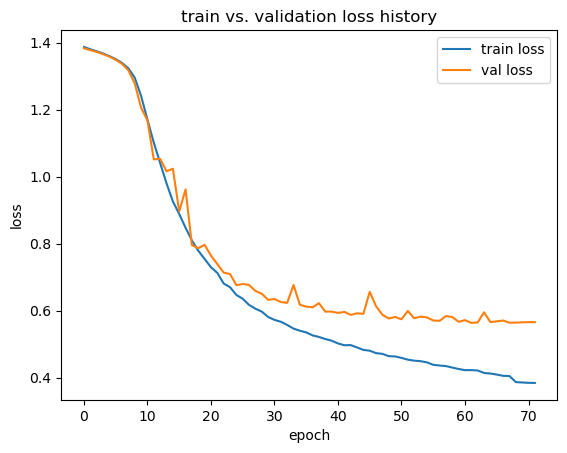

In [18]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Step 4. Test and evaluation

The code is the same as the previous sessions. We need to:
- Define a `test()` function to make predictions on the test set
- Compute the classification report for evaluation

In [19]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device) # move data to GPU
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [20]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())
    
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.5631358750661214
              precision    recall  f1-score   support

       World       0.81      0.81      0.81      9499
      Sports       0.86      0.87      0.86      9690
    Business       0.77      0.75      0.76      9530
     Sci/Tec       0.75      0.77      0.76      9561

    accuracy                           0.80     38280
   macro avg       0.80      0.80      0.80     38280
weighted avg       0.80      0.80      0.80     38280



## Step 5. Make predictions on unseen data

To use the trained mode, we can feed some unseen news articles and let the network make predictions. To do that, we can:
- Specify an unseen news article
- Define a `predict()` function for making predictions
    - Tokenize the unseen news article
    - Cut/Pad the sequence of tokens to the pre-defined length
    - Feed the sequence to the network and make prediction

In [21]:
# specify an unseen news article
unseen_news = 'Most stellar magnetic fields — including the Sun’s — are produced by a dynamo that is generated in interior layers undergoing convection. Massive stars (8 or more solar masses) do not have convective interiors, so it has been unclear why about 7% have magnetic fields. Using ESO’s Very Large Telescope Interferometer, astronomers have observed a binary massive star called HD 148937 and found that one member of the system is magnetic and appears to be younger than its companion. They argue that the system originally contained three or more stars and then experienced a merger that produced the magnetic star and made it appear younger.'
print(unseen_news)

Most stellar magnetic fields — including the Sun’s — are produced by a dynamo that is generated in interior layers undergoing convection. Massive stars (8 or more solar masses) do not have convective interiors, so it has been unclear why about 7% have magnetic fields. Using ESO’s Very Large Telescope Interferometer, astronomers have observed a binary massive star called HD 148937 and found that one member of the system is magnetic and appears to be younger than its companion. They argue that the system originally contained three or more stars and then experienced a merger that produced the magnetic star and made it appear younger.


In [22]:
# define a predict function to make prediction on unseen text
def predict(model, text):
    X = vocab(tokenizer(text))
    if len(X) < seq_length:
        X = X + [0] * (seq_length - len(X))
    else:
        X = X[:seq_length]
    X = np.array(X).reshape(1, -1) # add the batch dimension, batch_size = 1
    X = torch.tensor(X, dtype = torch.int64)
    logit = model(X.to(device))
    _, pred = torch.max(logit, 1)
    return pred.item()

In [23]:
print('The predicted calss is:', classes[predict(model, unseen_news)])

The predicted calss is: Sci/Tec
